In [6]:
import sys
import os
sys.path.append("modules")

from ukf_ex1 import *
from ukf_ex2 import *

import matplotlib.pyplot as plt
import aggregate_critique

## UKF Aggregate Critique.

In this notebook we discuss the failure of the unscented kalman filter (ukf) to perform under a certain aggregate case. We explore a number of potential causes as to why this occurs as well as a number of potential solutions. 

The aim is to not observed agents directly, but rather count how many lie within a certain grid square and calibrate our agent based model stationsim solely using these aggregates. We vary the width of the squares, dubbed `bin_size`, and expect that as the width approaches zero we have agents in squares small enough that we can approximate their true positions very well. However, this is not the case and we see that as we vary bin_size the overall prediction error of the ukf stays roughly constant. The aim of this notebook is to try and determine why the ukf is not working as intended here and propose any potential solutons. 
!! aggregate boxplot
!! grid square heatmap plot

## Kalman Gain Diagnostics

To diagnose the problem, we visualise the Kalman Gain of the unscented kalman filter $K$ over time. This gain is simply a ratio of covariances between our prediction (stationsim) and our observations. If the gain is low, it suggests the prediction has a low uncertainty relative to our observations. The Kalman Filter will react by not keeping its estimate close to the prediction ignoring observations. Likewise, high gain suggets high predictive uncertainty and the filter will react by moving its state estimates closer to our observations.

We also look at two other quantities seen as $\mu$ and $K\mu$. We take vector $\mu$ as a residual difference between our predicted observations (stationsim forecasts put through measurement function $h$) and our true observations. Larger element values in $\mu$ suggest larger discrepancies between prediction and observations and give larger movements for the kalman gain to act upon. $K\mu$ is simply a product of the two above quantities that gives a useful final result on how much the latent state predictions are moved by assimilation.

We calculate the three quantities above over the run time of our ABM. To visualise the results, we plot each element of the matrix over time as an individual line plot. If we have a ($i$x$j$) kalman gain matrix we will see $ij$ individual trajectories for K. This can appear messy but distinct features can easily be found. Plotting the element in the $i$th row and $j$th column corresponds to the gain on the $i$th element of the latent state from the $j$th observation. 

Plotting the elements of $\mu$ and $K\mu$ lets us see where the differences between the predictions and observations lie as well as how the filter reacts to them.


## Experiment 1 Example Diagnostics

In this section we propose examples of the above diagnostics for an experiment in which the ukf has seen success. This will be used as a control to determine where any problems may occur.

Experiment 1 is a simpler experiment where we do know the noisy gps style positions of agents. We usually observe some subset of these agents but for simplicity we observe every agent in a 10 agent model. This gives us a 20 dimensional state space with a (20x20) kalman gain matrix.

We plot each element of $K$ over time (figure 2) giving 400 individual trajectories. The vast majority of trajectories are near zero (380/400) with only 20 consistently non-zero trajectories (first figure below for an example). These 20 trajectories correspond with the diagonal entries of $K$. This occurs as our observations have a direct 1-to-1 mapping between our desired and observed state. In diagonal entries of $K$ we are using a prediction of some agent and assimilating it using the correct observation of said agent. If these two are close we see a high gain (near 1) and can see sharp drops in gain usually due to agent interaction. In off diagonal entries of $K$, we are comparing a prediction with the wrong observation. If the prediction and observation are far apart, as they usually are when comparing two totally different agents, the gain will virtually ignore the observation (near 0 gain). If by chance two agents are close together this wrong observation becomes more viable and we start to see non-zero gain. 

$\mu$ and $K\mu$ here are closely linked as expected (figures 3 and 4 below). In particular we are interested in the values of $K\mu$. We have 20 trajectories for each of our desired state indicating how much we correct our predictions after assimilating. Larger values generally indicate a poor prediction that requires a large correction. We see that for this low population model we see very few large corrections. Large peaks usually occur upon agent interactions or under the small chance of large gaussian noise values and quickly settle down.

This example demonstrates the ukf working properly and able to act upon times when the observations and predicition clearly differ. We use this as a benchmark to compare against the aggregate experiment to see the main differences.

Loading pickle ukf_agents_10_prop_1.0.pkl


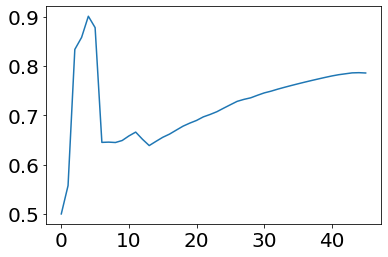

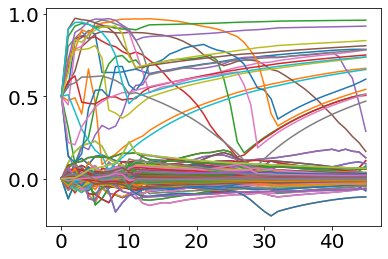

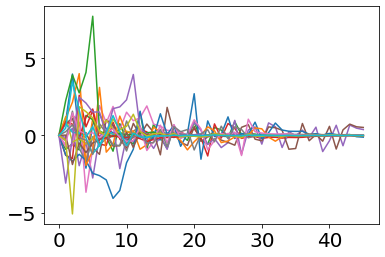

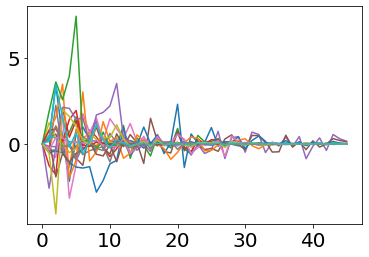

In [8]:
n = 10
prop = 1.0
f_name = f"ukf_agents_{n}_prop_{prop}.pkl"
ks, mus, kmus = aggregate_critique.main(f_name)

## Experiment 2 Kalman Gain

Having explored a case where the ukf works as desired, we present our aggregate case where the ukf fails to try and determine why using the established visualisation.

This time we see different kalman gain trajectories. In experiment 1 we saw the diagonal elements of the gain were constantly non-zero. This was due to 1-1 correspondance between each element of the observed and desired states. This does not apply in the aggeregate case as the grid square in which each agent is observed changes over time. We no longer see consistently non-zero gains but rather see peaks of temporary correspondance (figure 2) as an agent passes through a grid square.
This spiking presents an immediate problem as the UKF requires good choices of process and sensor noise stuctures to perform adequately. Our sensor noise structure is clearly time dependent and dynamically shifts as agents enter and leave squares. This makes the usual practice of searching for a good noise structure virtually impossible and in theory requires further augments such as adaptive filtering to perform properly.

We can also have multiple agents in each grid square such that each observed element can correspond to multiple desired elements. While this is not a problem for $K$, we can quickly see problems in $K\mu$ with the effects of data disassociation. Particularly, if we have multiple agents on a boundary between squares we will see differences in our observations but the filter will not be able to differentiate which agent is causing said difference. As a result it will move every agent according to its respective gains which can lead to major inaccuracies. We can clearly see the effects of this when plotting $\mu$ with several symmetric trajectories. In $K\mu$ 

We similar peaks in $\mu$ and $K\mu$ but for different reasons. As an agent reaches the bounadary of two grid squares we start generating sigma points either side of the boundary leading to large differences in observations and hence large $\mu$s. However, often these $\mu$ values come in symmetric pairs which cancel out in $K\mu$. If an agent is directly on the boundary we would expect sigmas points either side and $\mu$s either side that sum to 0.

- seems K isnt scaling up the densities to that of the observations so only tiny assimilations can be made.




Loading pickle agg_ukf_agents_5_bin_25.pkl


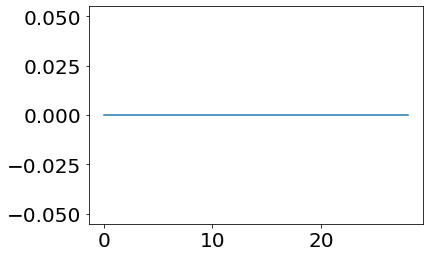

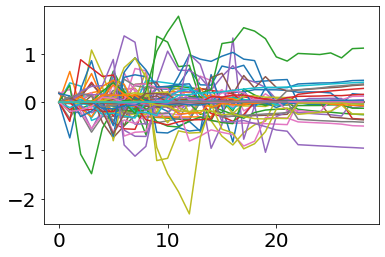

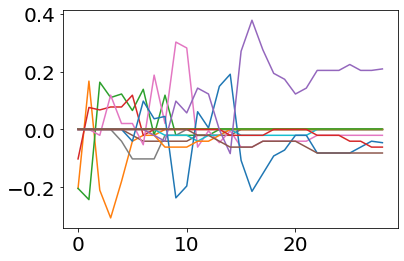

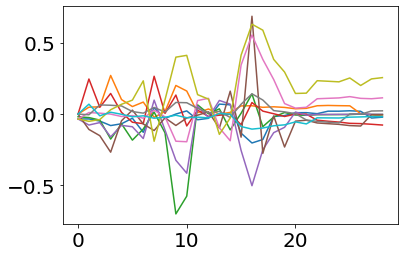

In [9]:
n = 5
bin_size = 25
    
f_name = f"agg_ukf_agents_{n}_bin_{bin_size}.pkl"  
#f_name = f"ukf_agents_{n}_bin_size{bin_size}.pkl"

ks, mus, kmus = aggregate_critique.main(f_name)

overdispersion
normal error
scaling
noise structure
high dimensional observations
cross covariance makes no sense
slam sensors?


## High dimensionality

The UKF is known to struggle with high dimensional scenarios. To quote Deng et al. (https://pdfs.semanticscholar.org/16d8/9be63d69ec53cec8f5c39a18a5259df8a3bb.pdf):

"The general UKF may not be stable, especially in a high-dimensional system. The inverse operation makes some large elements of the covariance matrix become very small. After a few operations, the elements which are close to zero become zero due to truncation errors. The accumulation and spread of truncation errors usually destroy the positive definiteness essential to a covariance matrix leading to the instability of numerical calculations in the general UKF."

and 

"The standard UKF has an excellent performance in the estimation of general nonlinear systems, but it has a poor performance in tracking mutation parameters and states. When the process noise is imprecise or the measurement noise is time-varying, the accuracy of general UKF would be greatly reduced. Thus, we should improve its ability to track catastrophe parameters and states. The adaptive UKF should also be adapted to the time-varying observation noise and the inaccurate process noise. Furthermore, the adaptive UKF should be stable enough for high-dimension systems."

- observation noise in aggregate case is very much time varying. 
- we are currently adding large amounts of noise to cases that are currently 0

https://arxiv.org/pdf/1701.05573.pdf pgds
https://www.math.leidenuniv.nl/scripties/MasterGu.pdf spatial kf
https://projecteuclid.org/download/pdfview_1/euclid.bjps/1481619620 spatial enkf for rainfall
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3998071/ 
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5456165
https://www.jstor.org/stable/pdf/2288936.pdf?refreqid=excelsior%3A741f9261ce1d36aecd81b2e56e6ec76f


hmm
MCMC style
abc style ensemble seems to work well but is basically enkf
likewise could sample points randomly around grid squares using gaussian mixture/hmc/qft
currently seems to be a few major problems
gaussian noise - some kind of generalised KF? some kind of glmm/GEE? some further state space e.g. poisson-gamma
sparsity/overdispersion - solve with dimension reduction etc.
lack of spatial/temporal correlations - some augments to filtering do this.



